<p>
<img src="http://www.cerm.unifi.it/chianti/images/logo%20unifi_positivo.jpg" 
        alt="UniFI logo" style="float: left; width: 20%; height: 20%;">
<div align="right">
Massimo Nocentini<br>
<small>
<br>December 7, 2016: CLT
<br>November 15, 2016: class
</small>
</div>
</p>
<br>
<br>
<div align="center">
<b>Abstract</b><br>
Lecture notes of today (November 15, 2016) class in Python, about simulation applied to Quicksort's checks and swaps.
</div>

In [1]:
from sympy import *
from sympy import stats
from numpy import linspace
import sys

from random import shuffle

from itertools import permutations
from statistics import mean, variance
from collections import namedtuple

sys.setrecursionlimit(10000000)

init_printing()

In [2]:
t, m, i, k, n, z = symbols('t m i k n z')
a, b = IndexedBase('a'), IndexedBase('b')

# Quicksort

In [3]:
CountData = namedtuple('CountData', ['checks', 'swaps'])

def counting_instrumented(quicksort):
    
    
    def instrumented(array, counting_data=True):

        checks, swaps = 0, 0

        def check_handler(index, pivot):
            nonlocal checks
            checks += 1

        def swap_handler(index, pivot):
            nonlocal swaps
            swaps += 1

        sorted_array = quicksort(array, check_handler, swap_handler)
        return (sorted_array, CountData(checks, swaps)) if counting_data else sorted_array
    
    return instrumented

In [4]:
@counting_instrumented
def quicksort(array, 
              check_performed=lambda index, pivot: None,
              swap_performed=lambda i, j: None):
    
    def rec(v):
        
        if not v: return v

        p = v[-1]
        i, j = -1, len(v)-1

        while i < j:

            i += 1
            check_performed(index=i, pivot=p)
            while v[i] < p: 
                check_performed(index=i, pivot=p)
                i += 1
            
            j -= 1
            check_performed(index=j, pivot=p)
            while 0 <= j and v[j] > p: 
                check_performed(index=j, pivot=p)
                j -= 1
                
            if i < j: 
                v[i], v[j] = v[j], v[i]
                swap_performed(i, j)

        v[i], v[-1] = v[-1], v[i] # discard this swap from counting

        return rec(v[:i]) + [p] + rec(v[i+1:])

    return rec(list(array))
    

In [5]:
array = list(range(10))
shuffle(array)
array

In [6]:
quicksort(array, counting_data=False)

In [7]:
array

In [8]:
sorted_array, data = quicksort(array, counting_data=True)

In [9]:
data.__str__()

'CountData(checks=42, swaps=3)'

In [10]:
assert sorted_array == sorted(array)

In [11]:
array

In [12]:
n = 4
perms = list(permutations(range(n)))
assert len(perms) == factorial(n)

In [13]:
perms

theoretical closed forms for the number of checks and swaps, _in the average case_:

In [14]:
def C(n):
    return 2*(n+1)*(harmonic(n+1)-1) if n else 0

def S(n):
    return 1/Integer(3)*(n+1)*(harmonic(n+1)-Integer(7)/3)+Integer(1)/2 if n > 1 else 0

In [37]:
StatData = namedtuple('StatData', ['mean', 'variance', 'sample_size'])

def simulation(f):
    
    def simulated(*args, **kwds):
        
        arrays = f(*args, **kwds)
        
        all_checks, all_swaps = [], []
        for sarray, (checks, swaps) in map(quicksort, arrays):
            all_checks.append(checks)
            all_swaps.append(swaps)

        # means
        checks_mean_observed, swaps_mean_observed = mean(all_checks), mean(all_swaps)
        
        # variance
        checks_var_observed, swaps_var_observed = variance(all_checks), variance(all_swaps)
        
        N = len(list(arrays))
        return (StatData(checks_mean_observed, checks_var_observed, N), 
                StatData(swaps_mean_observed, swaps_var_observed, N))
        

    return simulated

In [38]:
help(mean)

Help on function mean in module statistics:

mean(data)
    Return the sample arithmetic mean of data.
    
    >>> mean([1, 2, 3, 4, 4])
    2.8
    
    >>> from fractions import Fraction as F
    >>> mean([F(3, 7), F(1, 21), F(5, 3), F(1, 3)])
    Fraction(13, 21)
    
    >>> from decimal import Decimal as D
    >>> mean([D("0.5"), D("0.75"), D("0.625"), D("0.375")])
    Decimal('0.5625')
    
    If ``data`` is empty, StatisticsError will be raised.



In [39]:
help(variance)

Help on function variance in module statistics:

variance(data, xbar=None)
    Return the sample variance of data.
    
    data should be an iterable of Real-valued numbers, with at least two
    values. The optional argument xbar, if given, should be the mean of
    the data. If it is missing or None, the mean is automatically calculated.
    
    Use this function when your data is a sample from a population. To
    calculate the variance from the entire population, see ``pvariance``.
    
    Examples:
    
    >>> data = [2.75, 1.75, 1.25, 0.25, 0.5, 1.25, 3.5]
    >>> variance(data)
    1.3720238095238095
    
    If you have already calculated the mean of your data, you can pass it as
    the optional second argument ``xbar`` to avoid recalculating it:
    
    >>> m = mean(data)
    >>> variance(data, m)
    1.3720238095238095
    
    This function does not check that ``xbar`` is actually the mean of
    ``data``. Giving arbitrary values for ``xbar`` may lead to invalid or
   

In [40]:
@simulation
def all_permutations(n):
    return [list(perm) for perm in permutations(range(n))]

In [41]:
n = 5
(checks_mean, _, N), (swaps_mean, _, _) = all_permutations(n)

In [42]:
assert C(n) == checks_mean and S(n) == swaps_mean and N == factorial(n)

In [43]:
@simulation
def random_permutations(n, N):
    
    perm = list(range(n))
    
    perms = []
    
    for i in range(N):
        shuffle(perm)
        perms.append(list(perm))
    
    return perms

In [44]:
n = 8
checks_stat_data, swaps_stat_data = random_permutations(8, 8000)

In [45]:
print(checks_stat_data)

StatData(mean=32.92675, variance=7.982882297787223, sample_size=8000)


In [46]:
print(swaps_stat_data)

StatData(mean=1.987125, variance=0.7848073352919115, sample_size=8000)


In [47]:
n = 8
print('n!={} -> true checks mean: {:.5f}\ttrue swaps mean: {:.5f}\n'.format(
        factorial(n), C(n).evalf(), S(n).evalf()))

for N in range(1000, 8001, 500):
    (checks_mean, _, _), (swaps_mean, _, _) = random_permutations(n, N)
    print('N={} -> observed checks mean: {:.5f}\tobserved swaps mean: {:.5f}'.format(N, checks_mean, swaps_mean))

n!=40320 -> true checks mean: 32.92143	true swaps mean: 1.98690

N=1000 -> observed checks mean: 32.84600	observed swaps mean: 1.99300
N=1500 -> observed checks mean: 32.90467	observed swaps mean: 1.99067
N=2000 -> observed checks mean: 33.03350	observed swaps mean: 1.96900
N=2500 -> observed checks mean: 32.97240	observed swaps mean: 1.94320
N=3000 -> observed checks mean: 32.95667	observed swaps mean: 2.00633
N=3500 -> observed checks mean: 32.94086	observed swaps mean: 1.98400
N=4000 -> observed checks mean: 32.90175	observed swaps mean: 1.98800
N=4500 -> observed checks mean: 32.86756	observed swaps mean: 1.99622
N=5000 -> observed checks mean: 32.88060	observed swaps mean: 1.98980
N=5500 -> observed checks mean: 32.89127	observed swaps mean: 1.98764
N=6000 -> observed checks mean: 32.83117	observed swaps mean: 2.01850
N=6500 -> observed checks mean: 32.91308	observed swaps mean: 1.98154
N=7000 -> observed checks mean: 32.90000	observed swaps mean: 1.98743
N=7500 -> observed checks

In [48]:
dim, step = 100, 10
res = {i: random_permutations(i, i*step) for i in range(step, dim+1, step)}

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

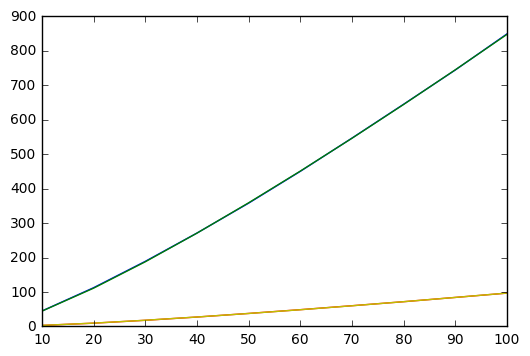

In [50]:
domain = sorted(res.keys())
plt.plot(domain, [res[k][0].mean for k in domain], 'b',
         domain, [C(n) for n in domain], 'g',
         domain, [res[k][1].mean for k in domain], 'r',
         domain, [S(n) for n in domain], 'y')
None

In [51]:
def draw_frequencies_histogram(seq, bins, normed=None, pdf=None):
    
    if callable(pdf):
        normed=True
        domain, theo_fn = pdf(seq)
        plt.plot(domain, [theo_fn(i) for i in domain], 'b')
    
    n, bins, patches = plt.hist(list(seq), bins, normed=normed, facecolor='green', alpha=0.5)
    
    plt.grid(True)
    plt.show()

In [52]:
def Normal_distribution(z, mean, std):
    Normal_rv = stats.Normal(symbols('x'), mean, std)
    pdf = stats.density(Normal_rv)
    return Lambda([z], pdf(z))

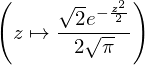

In [53]:
Normal_fn = Normal_distribution(z, 0, 1)
Normal_fn

In [63]:
n, N, samples = 8, 1000, 1000

checks_stats, swaps_stats = [], []

for i in range(samples):
    csd, ssd = random_permutations(n, N)
    checks_stats.append(csd)
    swaps_stats.append(ssd)

https://en.wikipedia.org/wiki/Central_limit_theorem#Classical_CLT

In [64]:
def CLT(stats, theoretical_mean):
    return [ sqrt(s.sample_size/s.variance)*(s.mean - theoretical_mean) for s in stats ]

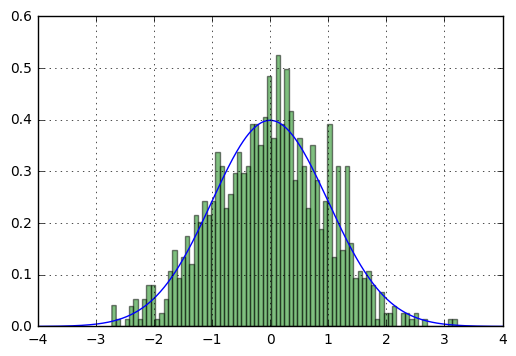

In [69]:
elements = CLT(checks_stats, theoretical_mean=C(n))
draw_frequencies_histogram(map(float, elements), bins=80,
                          pdf=lambda seq: (linspace(-4, 4, 1e3), Normal_fn))

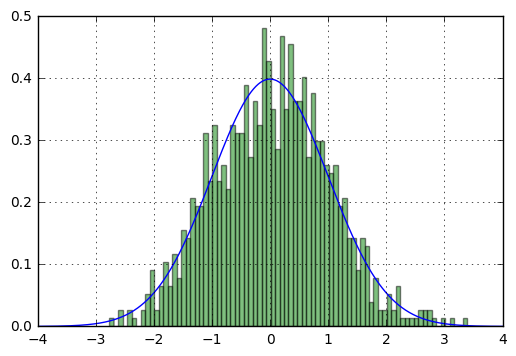

In [70]:
elements = CLT(swaps_stats, theoretical_mean=S(n))
draw_frequencies_histogram(map(float, elements), bins=80,
                          pdf=lambda seq: (linspace(-4, 4, 1e3), Normal_fn))

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.